In [1]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")
#sys.path.insert(0, r'/home/pirwin/Git/HelperPI')

import HelperPI
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sts
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, f1_score, matthews_corrcoef, make_scorer
from sklearn.grid_search import GridSearchCV

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [3]:
#sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\TAB_MODELING.sql")

In [4]:
#base, dtypesdf = helper.readData(sql)
base = pd.read_csv(r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\tab_model.csv', parse_dates=['DATE_VALUE'])
#base = pd.read_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/tab_model.csv',parse_dates=['DATE_VALUE'])
dtypes = helper.getDtypes(base)

                  Count     Column Type
0            DATE_VALUE  datetime64[ns]
1                RECORD          object
2            MEDHINC_CY         float64
3             MEDAGE_CY         float64
4            CLOSEST_BP         float64
5           CLOSEST_CAB         float64
6     MALES_IN_HOUSHOLD           int64
7   FEMALES_IN_HOUSHOLD           int64
8      REWARDS_CUSTOMER           int64
9      DAYS_AS_CUSTOMER           int64
10   TOTAL_TRANSACTIONS           int64
11     REW_TRANSACTIONS           int64
12          TOTAL_SPEND         float64
13  DAYS_SINCE_PURCHASE           int64
14     TARGET_VALUE12MO         float64
15  TARGET_PURCH_NEXT15           int64


### Imputing missing then Splitting the data for train and test using helper application

In [5]:
collist = ['MEDHINC_CY','MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_TRANSACTIONS','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE']
X = base[collist]
y = base['TARGET_PURCH_NEXT15']

### Determination of missing values

In [6]:
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / X.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.01]

,column_name,missing_count,missing_ratio
0,MEDHINC_CY,3792,0.03792
1,MEDAGE_CY,3792,0.03792


In [7]:
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr = imr.fit(X)
imputed_data = imr.transform(X.values)

train_X, test_X, train_y, test_y = train_test_split(imputed_data, y, test_size=0.3, random_state=0)

train_X = pd.DataFrame(train_X, columns=collist)
test_X = pd.DataFrame(test_X, columns=collist)

In [8]:
train_X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
MEDHINC_CY             70000 non-null float64
MEDAGE_CY              70000 non-null float64
CLOSEST_BP             70000 non-null float64
MALES_IN_HOUSHOLD      70000 non-null float64
FEMALES_IN_HOUSHOLD    70000 non-null float64
REWARDS_CUSTOMER       70000 non-null float64
DAYS_AS_CUSTOMER       70000 non-null float64
TOTAL_TRANSACTIONS     70000 non-null float64
REW_TRANSACTIONS       70000 non-null float64
TOTAL_SPEND            70000 non-null float64
DAYS_SINCE_PURCHASE    70000 non-null float64
dtypes: float64(11)
memory usage: 5.9 MB


In [9]:
#sns.pairplot(train_X)
#sns.plt.savefig('Scattermatrix.png')
#plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
train_X_std = pd.DataFrame(stdsc.fit_transform(train_X), columns=collist)
test_X_std = pd.DataFrame(stdsc.fit_transform(test_X), columns=collist)

#sns.pairplot(train_X_std)
#sns.plt.savefig('Scattermatrix.png')
#plt.show()

 1) DAYS_SINCE_PURCHASE            0.244832
 2) TOTAL_SPEND                    0.136975
 3) TOTAL_TRANSACTIONS             0.116767
 4) DAYS_AS_CUSTOMER               0.103328
 5) CLOSEST_BP                     0.096247
 6) MEDHINC_CY                     0.092551
 7) REW_TRANSACTIONS               0.086767
 8) MEDAGE_CY                      0.062995
 9) REWARDS_CUSTOMER               0.025845
10) MALES_IN_HOUSHOLD              0.018669
11) FEMALES_IN_HOUSHOLD            0.015023


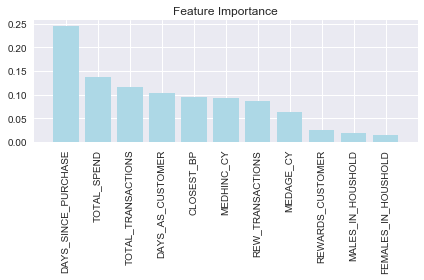

In [11]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = np.asarray(collist)

forests = RandomForestClassifier(n_estimators=1000,
                                random_state=0,
                                n_jobs=-1)
forests.fit(train_X_std, train_y)
importances = forests.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(train_X_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],
                                      importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(train_X_std.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(train_X_std.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, train_X_std.shape[1]])
plt.tight_layout()
plt.show()

### XGBoost Model

In [ ]:
import xgboost as xgb

xgb_params = {
    'booster': 'gbtree',
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'silent': 0,
    'seed' : 0,
    'eval_metric':'error',
    'max_delta_step' : 1
}
dtrain = xgb.DMatrix(train_X_std, train_y, feature_names=train_X.columns.values)
d_test = xgb.DMatrix(test_X_std, test_y, feature_names=test_X.columns.values)
model = xgb.train(xgb_params, dtrain, evals=[(d_test, "eval")], 
                  num_boost_round=1000, early_stopping_rounds=100)



fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

### Sklearn API version

[0]	validation_0-error:0.149414	validation_1-error:0.155033
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.145743	validation_1-error:0.154433
[2]	validation_0-error:0.145357	validation_1-error:0.153967
[3]	validation_0-error:0.141086	validation_1-error:0.1489
[4]	validation_0-error:0.139086	validation_1-error:0.144767
[5]	validation_0-error:0.1392	validation_1-error:0.146367
[6]	validation_0-error:0.1389	validation_1-error:0.1458
[7]	validation_0-error:0.137543	validation_1-error:0.143533
[8]	validation_0-error:0.137029	validation_1-error:0.143433
[9]	validation_0-error:0.136086	validation_1-error:0.141567
[10]	validation_0-error:0.136743	validation_1-error:0.1425
[11]	validation_0-error:0.136671	validation_1-error:0.142833
[12]	validation_0-error:0.135914	validation_1-error:0.141667
[13]	validation_0-error:0.134714	validation_1-error:0.140167
[14]

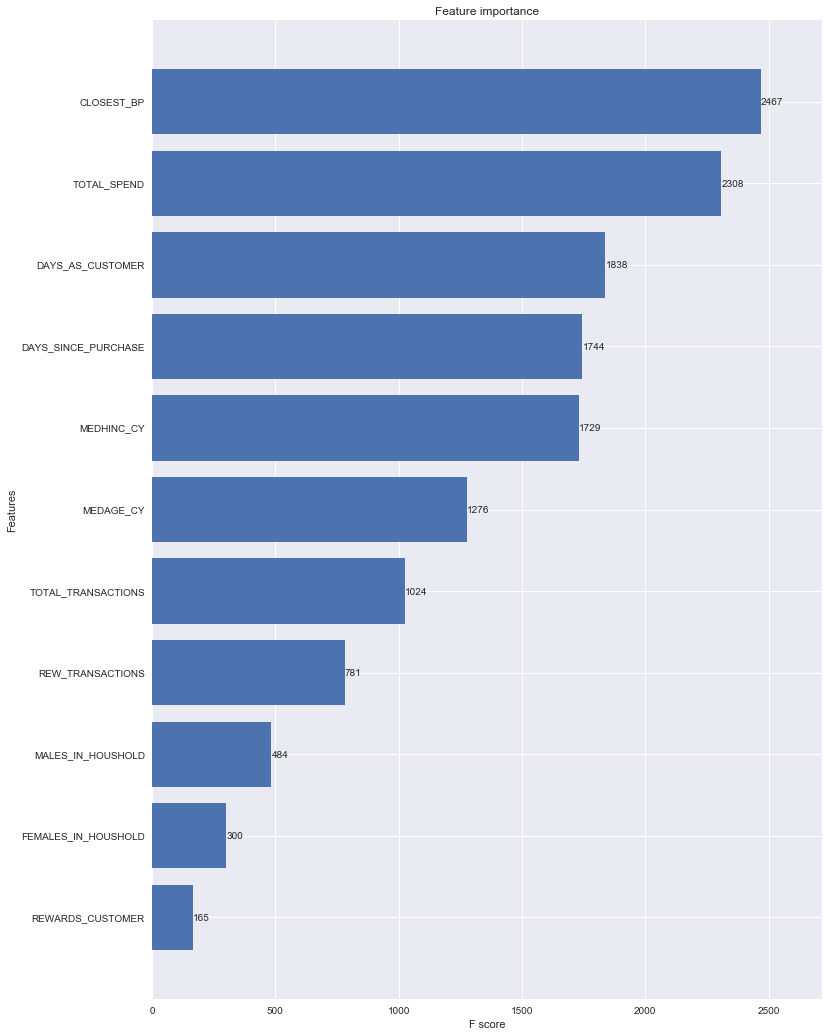

In [111]:
train_X_std = pd.DataFrame(stdsc.fit_transform(train_X), columns=collist)
test_X_std = pd.DataFrame(stdsc.fit_transform(test_X), columns=collist)

mod = xgb.XGBClassifier(max_depth=8, subsample=0.7, colsample_bytree=0.7, objective='binary:logistic', learning_rate=0.05, 
                       max_delta_step=0.5, seed=0)
fitted = mod.fit(train_X_std, train_y, 
                 eval_set=[(train_X_std, train_y), (test_X_std, test_y)], 
                 eval_metric='error',
                 early_stopping_rounds=100,
                 verbose=True)

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(fitted, height=0.8, ax=ax)
plt.show()

### Confusion matrix and ROC Curve

Accuracy: 86.84%


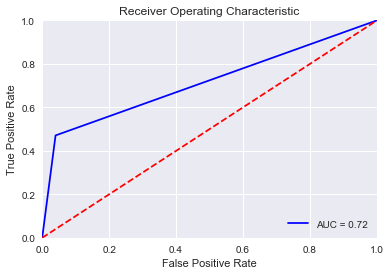

In [112]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
pred_y = fitted.predict(test_X_std)

#predictions = [round(value) for value in pred_y]
# evaluate predictions
accuracy = accuracy_score(test_y, pred_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Parameter Tuning Version

In [12]:
def modelfit(alg, dtrain, dlabels, feature_names, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=dlabels.values, feature_names = feature_names)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain, dlabels, eval_metric='auc')

    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dlabels.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dlabels.values, dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8732
AUC Score (Train): 0.890706


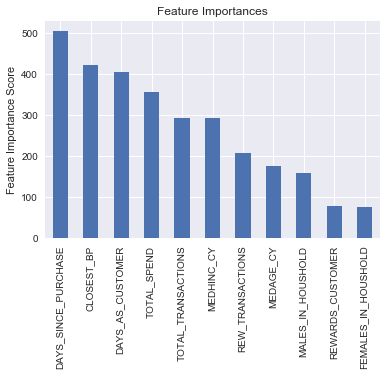

In [13]:
xgb1 = xgb.XGBClassifier(
    learning_rate = 0.07,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = 27)

modelfit(xgb1, train_X_std, train_y, collist)

In [14]:
auc_weighted = make_scorer(roc_auc_score, average='weighted')
auc_weighted

make_scorer(roc_auc_score, average=weighted)

In [36]:
param_test1 = {
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=300, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test1, scoring='f1', iid=False, cv=5)

gsearch1.fit(train_X.values, train_y.values)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.58415, std: 0.01273, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.58443, std: 0.01198, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.58391, std: 0.01249, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.58098, std: 0.01397, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.58108, std: 0.01227, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.58137, std: 0.01347, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.57403, std: 0.01448, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.57767, std: 0.01344, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.57617, std: 0.01112, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.57017, std: 0.01360, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.57061, std: 0.01245, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.57270, std: 0.01053, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 3

In [40]:
# max_depth = 5

param_test2 = {
    'min_child_weight':[2,3,4,5],
    'max_depth':[2,3,4,5]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=300, max_depth=4,
     min_child_weight=4, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test2, scoring ='f1', iid=False, cv=5)

gsearch2.fit(train_X.values, train_y.values)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.58162, std: 0.01139, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.58182, std: 0.01145, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.58155, std: 0.01124, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.58087, std: 0.01160, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.58182, std: 0.01224, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.58197, std: 0.01304, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.58238, std: 0.01268, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.58261, std: 0.01250, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.58414, std: 0.01314, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.58419, std: 0.01418, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.58435, std: 0.01271, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.58282, std: 0.01354, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.58256, std: 0.01117, params: {

In [41]:
#max_depth = 4
#min_child_weight = 4

param_test3 = {
    'gamma':[i/10.0 for i in range(0, 5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=300, max_depth=4,
     min_child_weight=4, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
     param_grid = param_test3, scoring = 'f1', iid=False, cv=5)

gsearch3.fit(train_X.values, train_y.values)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.58435, std: 0.01271, params: {'gamma': 0.0},
  mean: 0.58378, std: 0.01151, params: {'gamma': 0.1},
  mean: 0.58444, std: 0.01328, params: {'gamma': 0.2},
  mean: 0.58474, std: 0.01241, params: {'gamma': 0.3},
  mean: 0.58478, std: 0.01284, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.5847835392289742)


Model Report
Accuracy : 0.8725
AUC Score (Train): 0.889341


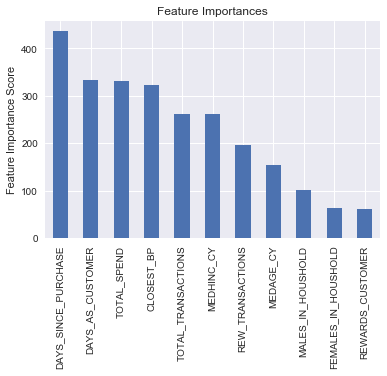

In [42]:
xgb2 = xgb.XGBClassifier(
    learning_rate = 0.07,
    n_estimators = 1000,
    max_depth = 4,
    min_child_weight = 4,
    gamma = 0.4,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = 27)

modelfit(xgb2, train_X_std, train_y, collist)

In [44]:
#max_depth = 4
#min_child_weight = 4
#gamma = 0.4

param_test4 = {
    'subsample':[i/10.0 for i in range(3, 10)],
    'colsample_bytree':[i/10.0 for i in range(4, 10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=140, max_depth=4,
     min_child_weight=4, gamma=0.4, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test4, scoring = 'f1', iid=False, cv=5)

gsearch4.fit(train_X.values, train_y.values)

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.58100, std: 0.01348, params: {'colsample_bytree': 0.4, 'subsample': 0.3},
  mean: 0.58203, std: 0.01210, params: {'colsample_bytree': 0.4, 'subsample': 0.4},
  mean: 0.58146, std: 0.01158, params: {'colsample_bytree': 0.4, 'subsample': 0.5},
  mean: 0.58309, std: 0.01153, params: {'colsample_bytree': 0.4, 'subsample': 0.6},
  mean: 0.58304, std: 0.01293, params: {'colsample_bytree': 0.4, 'subsample': 0.7},
  mean: 0.58283, std: 0.01370, params: {'colsample_bytree': 0.4, 'subsample': 0.8},
  mean: 0.58157, std: 0.01248, params: {'colsample_bytree': 0.4, 'subsample': 0.9},
  mean: 0.58247, std: 0.01221, params: {'colsample_bytree': 0.5, 'subsample': 0.3},
  mean: 0.58557, std: 0.01261, params: {'colsample_bytree': 0.5, 'subsample': 0.4},
  mean: 0.58542, std: 0.01384, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: 0.58504, std: 0.01421, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.58338, std: 0.01359, params: {'colsample_bytree': 0.5, 'subsample'

In [45]:
#max_depth = 4
#min_child_weight = 4
#gamma = 0.4
#subsample = 0.4
#colsample_bytree = 0.5

param_test5 = {

    'colsample_bytree':[i/100.0 for i in range(30, 65, 5)],
    'subsample':[i/100 for i in range(30,65,5)]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=140, max_depth=4,
     min_child_weight=4, gamma=0.4, subsample=0.4, colsample_bytree=0.5,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test5, scoring = 'f1', iid=False, cv=5)

gsearch5.fit(train_X.values, train_y.values)

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.57567, std: 0.01152, params: {'colsample_bytree': 0.3, 'subsample': 0.3},
  mean: 0.57553, std: 0.01165, params: {'colsample_bytree': 0.3, 'subsample': 0.35},
  mean: 0.57875, std: 0.01072, params: {'colsample_bytree': 0.3, 'subsample': 0.4},
  mean: 0.57692, std: 0.01112, params: {'colsample_bytree': 0.3, 'subsample': 0.45},
  mean: 0.57674, std: 0.01073, params: {'colsample_bytree': 0.3, 'subsample': 0.5},
  mean: 0.57681, std: 0.00952, params: {'colsample_bytree': 0.3, 'subsample': 0.55},
  mean: 0.57624, std: 0.01278, params: {'colsample_bytree': 0.3, 'subsample': 0.6},
  mean: 0.57567, std: 0.01152, params: {'colsample_bytree': 0.35, 'subsample': 0.3},
  mean: 0.57553, std: 0.01165, params: {'colsample_bytree': 0.35, 'subsample': 0.35},
  mean: 0.57875, std: 0.01072, params: {'colsample_bytree': 0.35, 'subsample': 0.4},
  mean: 0.57692, std: 0.01112, params: {'colsample_bytree': 0.35, 'subsample': 0.45},
  mean: 0.57674, std: 0.01073, params: {'colsample_bytree': 0.35, '

In [47]:
#max_depth = 4
#min_child_weight = 4
#gamma = 0.4
#subsample = 0.4
#colsample_bytree = 0.5

param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=300, max_depth=4,
     min_child_weight=4, gamma=0.4, subsample=0.4, colsample_bytree=0.5,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test6, scoring = 'f1', iid=False, cv=5)

gsearch6.fit(train_X.values, train_y.values)

gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.58218, std: 0.01175, params: {'reg_alpha': 1e-05},
  mean: 0.58358, std: 0.01300, params: {'reg_alpha': 0.01},
  mean: 0.58050, std: 0.01361, params: {'reg_alpha': 0.1},
  mean: 0.58148, std: 0.01375, params: {'reg_alpha': 1},
  mean: 0.58564, std: 0.01113, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 0.5856410113356552)

In [48]:
#max_depth = 4
#min_child_weight = 4
#gamma = 0.4
#subsample = 0.4
#colsample_bytree = 0.5
#reg_alpha = 100

param_test7 = {
    'reg_alpha':[80, 90, 100, 110, 120, 130, 140]
}

gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.07, n_estimators=300, max_depth=4,
     min_child_weight=4, gamma=0.4, subsample=0.4, colsample_bytree=0.5,
     objective= 'binary:logistic', scale_pos_weight=1, seed=27),
     param_grid = param_test7, scoring = 'f1', iid=False, cv=5)

gsearch7.fit(train_X.values, train_y.values)

gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.58550, std: 0.01107, params: {'reg_alpha': 80},
  mean: 0.58471, std: 0.01057, params: {'reg_alpha': 90},
  mean: 0.58564, std: 0.01113, params: {'reg_alpha': 100},
  mean: 0.58378, std: 0.01106, params: {'reg_alpha': 110},
  mean: 0.58302, std: 0.01136, params: {'reg_alpha': 120},
  mean: 0.58141, std: 0.01186, params: {'reg_alpha': 130},
  mean: 0.58073, std: 0.01284, params: {'reg_alpha': 140}],
 {'reg_alpha': 100},
 0.5856410113356552)


Model Report
Accuracy : 0.8679
AUC Score (Train): 0.877450


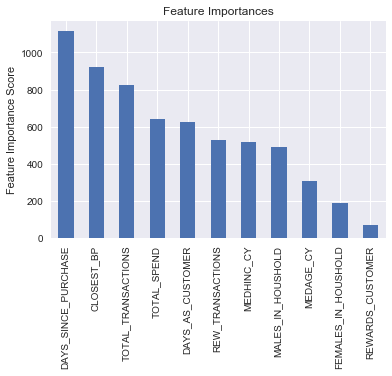

In [49]:
xgb3 = xgb.XGBClassifier(
    learning_rate = 0.01,
    n_estimators = 1000,
    max_depth = 4,
    min_child_weight = 4,
    gamma = 0.4,
    subsample = 0.4,
    colsample_bytree = 0.55,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    reg_alpha=100,
    seed = 27)

modelfit(xgb3, train_X_std, train_y, collist)

[0]	validation_0-error:0.160214	validation_1-error:0.160167
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.142186	validation_1-error:0.141633
[2]	validation_0-error:0.145514	validation_1-error:0.144133
[3]	validation_0-error:0.146843	validation_1-error:0.145533
[4]	validation_0-error:0.147714	validation_1-error:0.146233
[5]	validation_0-error:0.147871	validation_1-error:0.147167
[6]	validation_0-error:0.149471	validation_1-error:0.148133
[7]	validation_0-error:0.146114	validation_1-error:0.144267
[8]	validation_0-error:0.143743	validation_1-error:0.141233
[9]	validation_0-error:0.144157	validation_1-error:0.141767
[10]	validation_0-error:0.142443	validation_1-error:0.141133
[11]	validation_0-error:0.141757	validation_1-error:0.140567
[12]	validation_0-error:0.142386	validation_1-error:0.1413
[13]	validation_0-error:0.143014	validation_1-error:0.1419

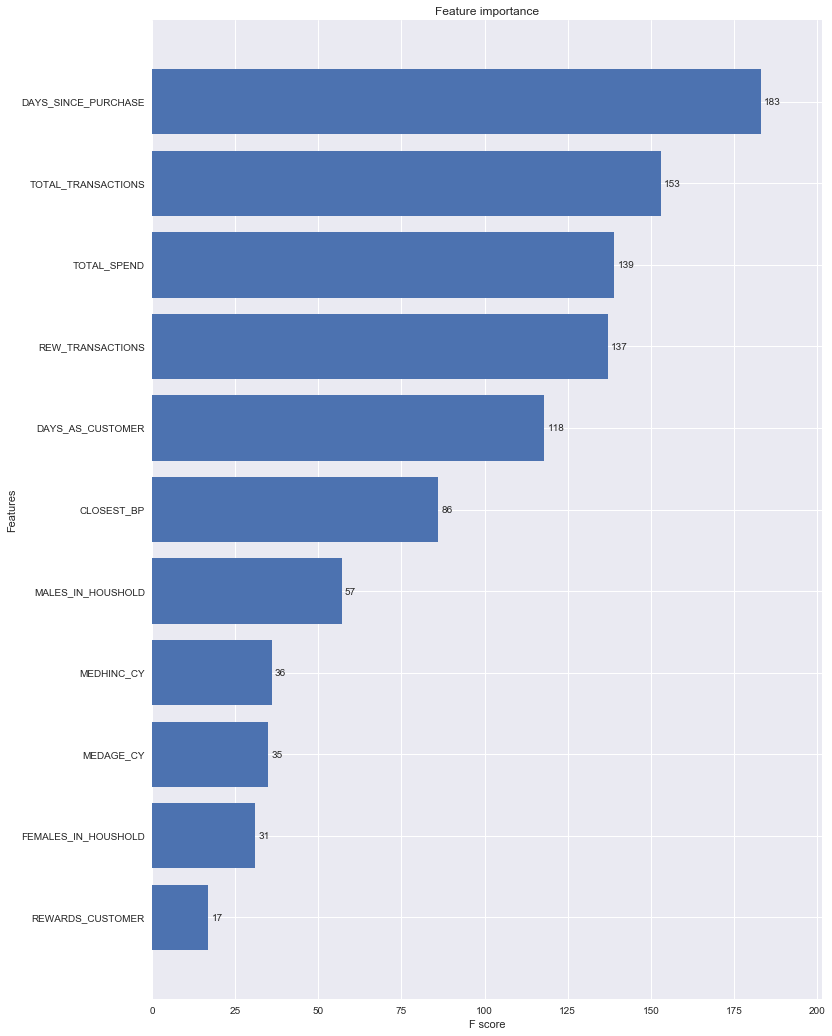

In [50]:
tuned_model = xgb.XGBClassifier(learning_rate = 0.01,
                        n_estimators = 1000,
                        max_depth = 4,
                        min_child_weight = 4,
                        gamma = 0.4,
                        subsample = 0.4,
                        colsample_bytree = 0.5,
                        objective = 'binary:logistic',
                        scale_pos_weight = 1,
                        reg_alpha=100,
                        seed = 27)
fitted = tuned_model.fit(train_X_std, train_y, 
                 eval_set=[(train_X_std, train_y), (test_X_std, test_y)], 
                 eval_metric='error',
                 early_stopping_rounds=50,
                 verbose=True)

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(fitted, height=0.8, ax=ax)
plt.show()

Accuracy: 86.41%


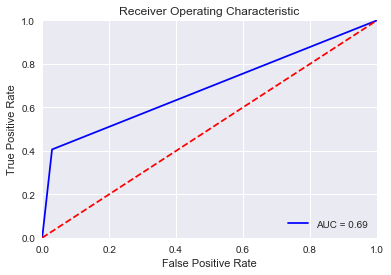

In [51]:
pred_y = fitted.predict(test_X_std)

predictions = [round(value) for value in pred_y]
# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### sklearn mlpclassifier

In [16]:
from sklearn.neural_network import MLPClassifier

In [17]:

clf = MLPClassifier(activation='logistic', early_stopping=True, learning_rate='adaptive', learning_rate_init=.0001, 
                    verbose=True, validation_fraction=0.1)
clf.fit(train_X_std, train_y)

Iteration 1, loss = 0.38891664
Validation score: 0.854986
Iteration 2, loss = 0.34260629
Validation score: 0.858986
Iteration 3, loss = 0.33940881
Validation score: 0.859443
Iteration 4, loss = 0.33852282
Validation score: 0.860357
Iteration 5, loss = 0.33775414
Validation score: 0.860543
Iteration 6, loss = 0.33707289
Validation score: 0.860800
Iteration 7, loss = 0.33646304
Validation score: 0.861243
Iteration 8, loss = 0.33590957
Validation score: 0.861257
Iteration 9, loss = 0.33541205
Validation score: 0.861186
Iteration 10, loss = 0.33489584
Validation score: 0.861729
Iteration 11, loss = 0.33438966
Validation score: 0.862257
Iteration 12, loss = 0.33387056
Validation score: 0.862114
Iteration 13, loss = 0.33331516
Validation score: 0.862843
Iteration 14, loss = 0.33276741
Validation score: 0.862486
Iteration 15, loss = 0.33219868
Validation score: 0.862957
Iteration 16, loss = 0.33160192
Validation score: 0.863286
Iteration 17, loss = 0.33100872
Validation score: 0.864014
Iterat

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.0001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

Accuracy: 86.12%


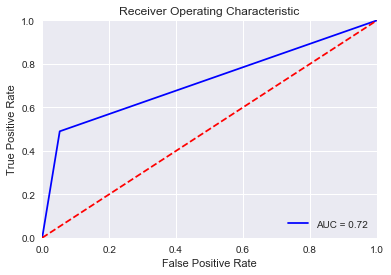

In [18]:
pred_y = clf.predict(test_X_std)

accuracy = accuracy_score(test_y, pred_y)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


fpr, tpr, _ = roc_curve(test_y, pred_y)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [170]:
clf.predict_proba(test_X_std)

array([[ 0.14276817,  0.85723183],
       [ 0.57737186,  0.42262814],
       [ 0.93198685,  0.06801315],
       ..., 
       [ 0.93193459,  0.06806541],
       [ 0.69055288,  0.30944712],
       [ 0.58447264,  0.41552736]])

In [77]:
np.all(np.isfinite(test_X))

True

In [79]:
np.any(np.isnan(test_X))

False